In [53]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import shutil
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.applications import MobileNet


In [54]:
base_dir = "./data/ui_icons_dataset/"
train_dir = (os.path.join(base_dir,"train/"))
validation_dir = os.path.join(base_dir, "validation/")

In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.3,
      height_shift_range=0.3,
      shear_range=0.3,
      zoom_range=0.3,
      horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(224, 224),
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        class_mode='categorical')

Found 11249 images belonging to 21 classes.
Found 1241 images belonging to 21 classes.


In [57]:
EPOCHS = 5
STEPS = 120

In [58]:
def create_model():
    batch_size = 20
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    predictions = tf.keras.layers.Dense(21, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [59]:
model = create_model()
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5,min_delta=0.005, mode='max', verbose=1),
 ModelCheckpoint('Xception.h5', monitor='val_loss', mode='max', save_best_only=True, save_weights_only=True),
 EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
history = model.fit( train_generator, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,validation_data = validation_generator,callbacks = callbacks)


Epoch 1/5
120/120 [==============================] - 184s 2s/step - loss: 1.8973 - accuracy: 0.4245 - val_loss: 1.5558 - val_accuracy: 0.4883 - lr: 0.0010
Epoch 2/5
120/120 [==============================] - 178s 1s/step - loss: 1.4756 - accuracy: 0.5409 - val_loss: 1.3828 - val_accuracy: 0.5463 - lr: 0.0010
Epoch 3/5
120/120 [==============================] - 179s 1s/step - loss: 1.3714 - accuracy: 0.5672 - val_loss: 1.3078 - val_accuracy: 0.6035 - lr: 0.0010
Epoch 4/5
120/120 [==============================] - 178s 1s/step - loss: 1.3076 - accuracy: 0.5724 - val_loss: 1.2717 - val_accuracy: 0.5882 - lr: 0.0010
Epoch 5/5
120/120 [==============================] - 182s 2s/step - loss: 1.2609 - accuracy: 0.5862 - val_loss: 1.2617 - val_accuracy: 0.6100 - lr: 0.0010


Text(0.5, 1.0, 'Training and validation loss')

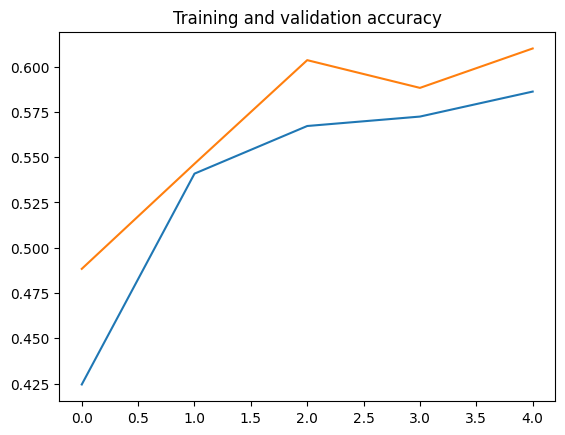

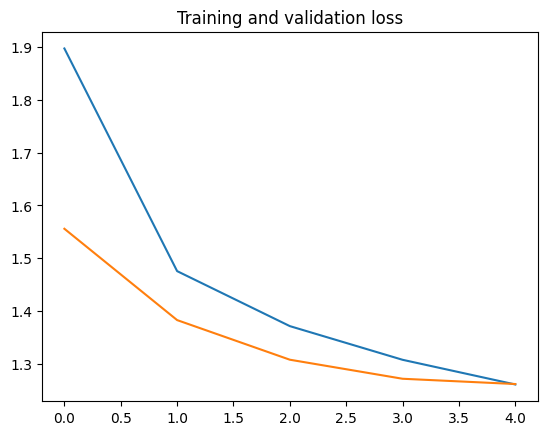

In [60]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()


plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [61]:
model_save_path = 'xception'

# Save the model
model.save(model_save_path)

INFO:tensorflow:Assets written to: xception\assets


INFO:tensorflow:Assets written to: xception\assets


In [62]:
model_test  = tf.keras.models.load_model('xception')

base_dir = "./data/ui_icons_dataset/"
test_dir = os.path.join(base_dir, "test/test")

IDs2 = []
Target2 = []

for i in range(len(os.listdir(test_dir))):
    image = cv2.imread(os.path.join(test_dir,os.listdir(test_dir)[i]))
    image = cv2.resize(image,(224,224)) 
    image = image.reshape(1,224,224,3)

    IDs2.append(os.listdir(test_dir)[i])

    prediction = model_test.predict(image)
    max_index = np.argmax(prediction)

    Target2.append(os.listdir(train_dir)[max_index])
            
df2 = pd.DataFrame({'ID': IDs2, 'Target': Target2})

1/1 [==============================] - 0s 300ms/step


In [63]:
df2.to_csv('predictions_xception.csv', index=False)

In [64]:
df = pd.read_csv("predictions_xception.csv")

In [65]:
class_counts = df['Target'].value_counts()

# Display the class counts
print(class_counts)

Target
alert                     1629
slider                    1606
switch_enabled            1319
data_table                 357
switch_disabled            120
label                       54
menu                        31
radio_button_unchecked      22
radio_button_checked         3
floating_action_button       1
chip                         1
Name: count, dtype: int64


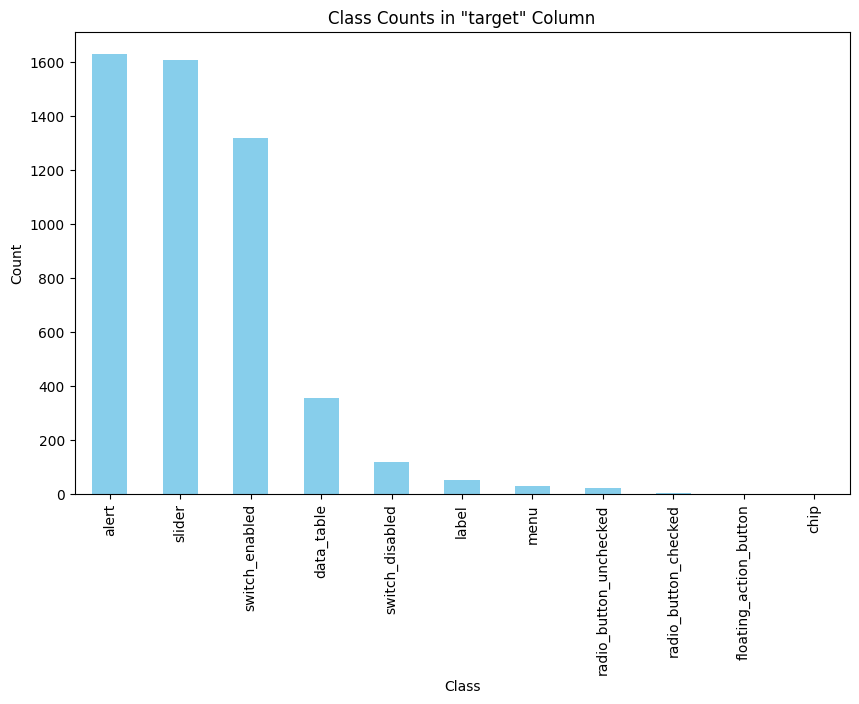

In [66]:
class_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Class Counts in "target" Column')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()